In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
scotty pippen jr.,24,21.3,111.0,109.7,1.3,28.3,2.51,30.3,3.5,10.5,...,35.4,109.7,10.5,29.9,14.9,8.4,6.7,6.9,20.6,0.081
nicolas batum,36,17.5,110.5,104.7,5.9,8.2,2.47,23.0,3.4,11.7,...,8.7,104.7,11.7,20.9,24.7,6.2,4.6,5.5,16.4,0.093
alperen sengun,22,31.5,114.9,107.4,7.6,23.8,1.92,19.6,9.9,21.0,...,51.0,107.4,21.0,20.6,25.7,9.9,8.8,9.3,31.7,0.139
amir coffey,28,24.3,109.1,110.6,-1.4,6.5,1.71,11.2,1.9,7.2,...,19.6,110.6,7.2,13.3,4.3,9.5,6.7,8.0,24.3,0.086
deni avdija,24,30.0,113.6,114.5,-0.9,19.3,1.43,19.0,4.8,19.0,...,42.8,114.5,19.0,20.4,15.0,11.1,9.1,11.0,29.6,0.072


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,scotty pippen jr.,24,21.3,111.0,109.7,1.3,28.3,2.51,30.3,3.5,...,35.4,109.7,10.5,29.9,14.9,8.4,6.7,6.9,20.6,0.081
1,nicolas batum,36,17.5,110.5,104.7,5.9,8.2,2.47,23.0,3.4,...,8.7,104.7,11.7,20.9,24.7,6.2,4.6,5.5,16.4,0.093
2,alperen sengun,22,31.5,114.9,107.4,7.6,23.8,1.92,19.6,9.9,...,51.0,107.4,21.0,20.6,25.7,9.9,8.8,9.3,31.7,0.139
3,amir coffey,28,24.3,109.1,110.6,-1.4,6.5,1.71,11.2,1.9,...,19.6,110.6,7.2,13.3,4.3,9.5,6.7,8.0,24.3,0.086
4,deni avdija,24,30.0,113.6,114.5,-0.9,19.3,1.43,19.0,4.8,...,42.8,114.5,19.0,20.4,15.0,11.1,9.1,11.0,29.6,0.072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,kawhi leonard,34,31.9,120.3,107.9,12.4,14.7,1.61,13.5,3.3,...,50.6,107.9,15.8,24.1,15.0,9.2,7.7,8.8,29.4,0.134
353,jarred vanderbilt,26,16.1,115.6,112.2,3.3,9.4,1.41,19.9,11.4,...,25.4,112.2,19.4,34.7,27.0,5.9,4.8,5.8,17.4,0.050
354,dante exum,29,18.6,109.3,115.2,-6.0,22.0,2.55,24.8,1.0,...,40.6,115.2,7.4,20.7,6.8,5.7,5.6,6.0,23.8,0.041
355,jordan goodwin,26,18.7,111.2,112.4,-1.2,10.8,1.62,19.4,6.8,...,33.3,112.4,13.5,26.3,22.9,7.3,5.8,8.0,17.9,0.056


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4340405062510419
Variance with 3 components: 0.5462548221216881
Variance with 4 components: 0.6465236961712006
Variance with 5 components: 0.6995673983525085
Variance with 6 components: 0.7447144091690898
Variance with 7 components: 0.7810513747832006
Variance with 8 components: 0.8112037072635828
Variance with 9 components: 0.8370092649012582
Variance with 10 components: 0.8606882110517332
Variance with 11 components: 0.8801891873468329
Variance with 12 components: 0.8991417357330808
Variance with 13 components: 0.9128809332457487
Variance with 14 components: 0.9262240249020957
Variance with 15 components: 0.9389202835050949
Variance with 16 components: 0.9497211215419797
Variance with 17 components: 0.9597082478216068
Variance with 18 components: 0.9681528570784733
Variance with 19 components: 0.975984708540649
Variance with 20 components: 0.9825231658695925
Variance with 21 components: 0.9868143369938086
Variance with 22 components: 0.9902559344631241
V

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

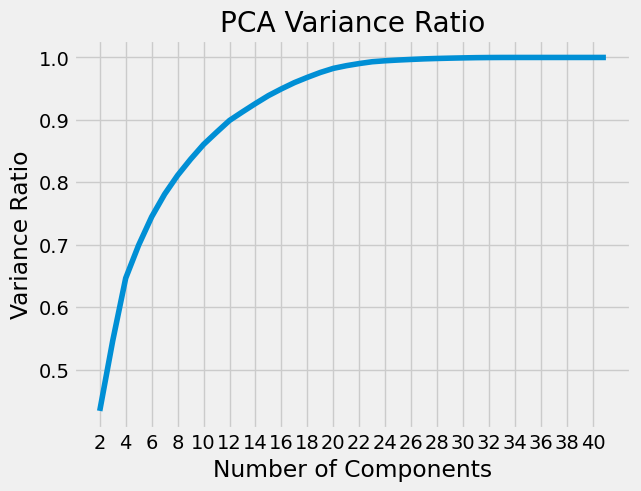

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.12214316e-01 1.00268874e-01 5.30437022e-02 4.51470108e-02
 3.63369656e-02 3.01523325e-02 2.58055576e-02 2.36789462e-02
 1.95009763e-02 1.89525484e-02 1.37391975e-02 1.33430917e-02
 1.26962586e-02 1.08008380e-02 9.98712628e-03 8.44460926e-03
 7.83185146e-03 6.53845733e-03 4.29117112e-03 3.44159747e-03
 2.89733652e-03 1.56094629e-03 1.17424522e-03 9.72594677e-04
 8.89634705e-04 6.39196605e-04 5.03070339e-04 4.34906549e-04
 3.53299715e-04 2.02860894e-04 1.00894499e-04 1.43203737e-05
 6.68542483e-07 8.29703919e-08 5.25523214e-09 2.38689579e-09
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

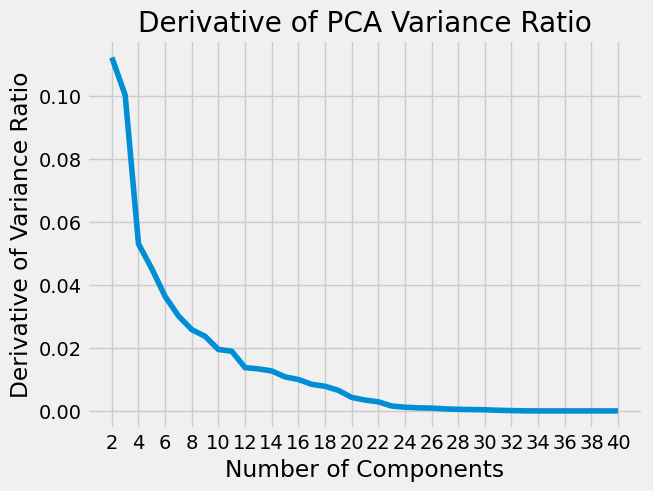

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.22427621 0.20976429 0.11221432 0.10026887 0.0530437  0.04514701
 0.03633697 0.03015233 0.02580556 0.02367895 0.01950098 0.01895255
 0.0137392  0.01334309 0.01269626 0.01080084]
0.9497211215419797


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.15858032286466142
Silhouette Score with 3 clusters: 0.1925226563617083
Silhouette Score with 4 clusters: 0.1424237144587865
Silhouette Score with 5 clusters: 0.1308591502093048
Silhouette Score with 6 clusters: 0.11983256104529143
Silhouette Score with 7 clusters: 0.12312516069021809
Silhouette Score with 8 clusters: 0.11905954092490945
Silhouette Score with 9 clusters: 0.11318201931887797
Silhouette Score with 10 clusters: 0.1174008001746995
Silhouette Score with 11 clusters: 0.10267349295376135
Silhouette Score with 12 clusters: 0.0949344278688271
Silhouette Score with 13 clusters: 0.1015495301333704
Silhouette Score with 14 clusters: 0.09597595288675753
Silhouette Score with 15 clusters: 0.09370088342192398
Silhouette Score with 16 clusters: 0.09682073162018925
Silhouette Score with 17 clusters: 0.0922146512017543
Silhouette Score with 18 clusters: 0.08896306940973157
Silhouette Score with 19 clusters: 0.08736212741150425
Silhouette Score with 20 

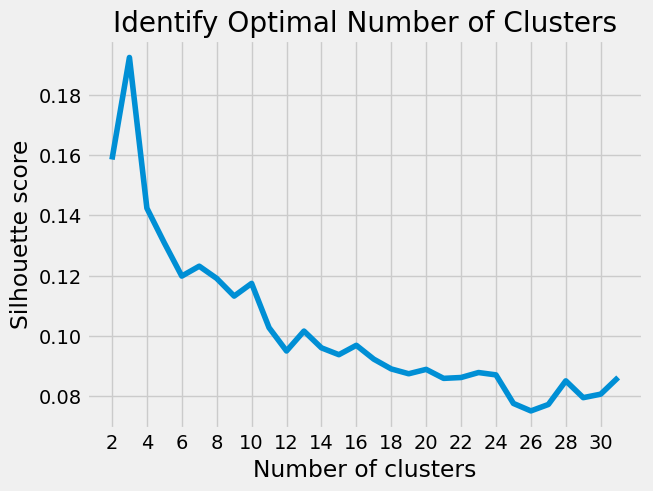

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluster = {i + 2}, improvement = {improvement}") 

for n_cluster = 3, improvement = 0.04033936265028348
for n_cluster = 4, improvement = -0.0620437741041604
for n_cluster = 5, improvement = -0.013485172624827513
for n_cluster = 6, improvement = -0.012686768970379125
for n_cluster = 7, improvement = 0.003740878722845009
for n_cluster = 8, improvement = -0.004636488108734849
for n_cluster = 9, improvement = -0.006671871572571764
for n_cluster = 10, improvement = 0.004757211680103013
for n_cluster = 11, improvement = -0.016686291154414556
for n_cluster = 12, improvement = -0.008624580934769366
for n_cluster = 13, improvement = 0.00730897568997857
for n_cluster = 14, improvement = -0.006203544250402926
for n_cluster = 15, improvement = -0.0025166028183634115
for n_cluster = 16, improvement = 0.00344240454525091
for n_cluster = 17, improvement = -0.005099851800958177
for n_cluster = 18, improvement = -0.003581883973262423
for n_cluster = 19, improvement = -0.0017572745346228213
for n_cluster = 20, improvement = 0.0015920341031698815
for n_c

C:\conda_tmp\ipykernel_34220\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


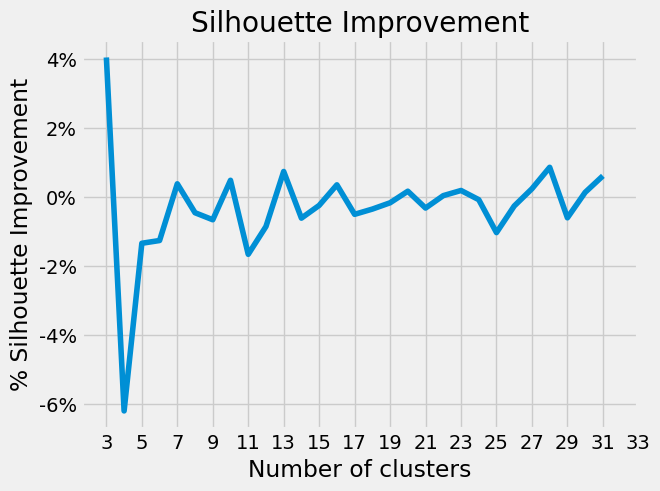

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,scotty pippen jr.,9
1,nicolas batum,7
2,alperen sengun,2
3,amir coffey,1
4,deni avdija,11


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()